# Example notebook: Simulating SKA-Low noise

**Authors**: Sambit K. Giri, Adelie Gorce, Ian Hothi <br>
**Date created**: 2 June 2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from astropy.cosmology import Planck18 as cos
from astropy import units, constants
from tqdm import tqdm
#For Power Spectrum Calculations 
import tools21cm as t2c

In [2]:
seed = 123456 # Choose your favorite number
np.random.seed(seed)

## Load metadata and simulation

In [3]:
# Folder containing the simulations
ddir = './SKA_chapter_simulations/'
# File with fiducial lightcone
file = ddir+'Lightcone_FID_400_Samples.h5'

In [4]:
# Read h5py file to obtain metadata
with h5py.File(file, 'r') as f:
    frequencies = f['frequencies'][...]  # frequencies along the lightcone
    redshifts = f['redshifts'][...]  # redshifts along the lightcone
    box_length = float(f['box_length'][0])  # Mpc
    ngrid = int(f['ngrid'][0])  # number of pixels along the sky patch
    nrand = int(f['nrealisations'][0])  # number of realisations for a given parameter set
nfreq = frequencies.size
print(f'Lightcone runs from z={redshifts.min():.2f} to z = {redshifts.max():.2f}.')

Lightcone runs from z=8.82 to z = 9.33.


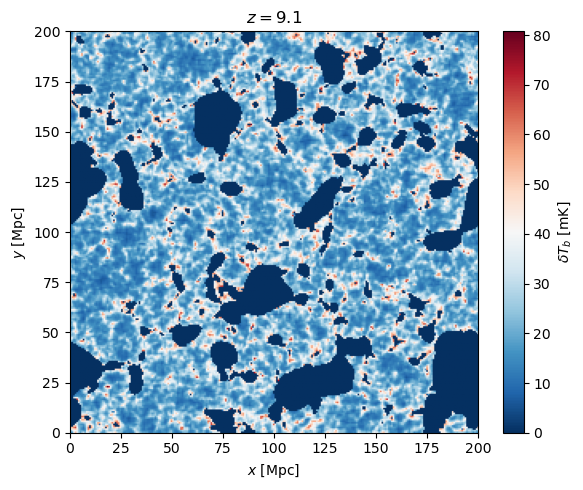

In [5]:
# Read h5py file for iz-th redshift and i-th realisation
iz = np.random.randint(nfreq)
i = np.random.randint(nrand)

with h5py.File(file, 'r') as f:
    coeval_slice = f['brightness_lightcone'][i, iz, :, :]  # Reads only (nz, n, n), not entire data

iz = 50

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(
    coeval_slice,
    extent=(0, box_length, 0, box_length),
    origin='lower', cmap='RdBu_r', aspect='auto'
    )
ax.set_xlabel(r'$x$ [Mpc]')
ax.set_ylabel(r'$y$ [Mpc]')
plt.colorbar(im, label=r'$\delta T_b$ [mK]')
ax.set_title(rf'$z={redshifts[iz]:.1f}$')
fig.tight_layout()

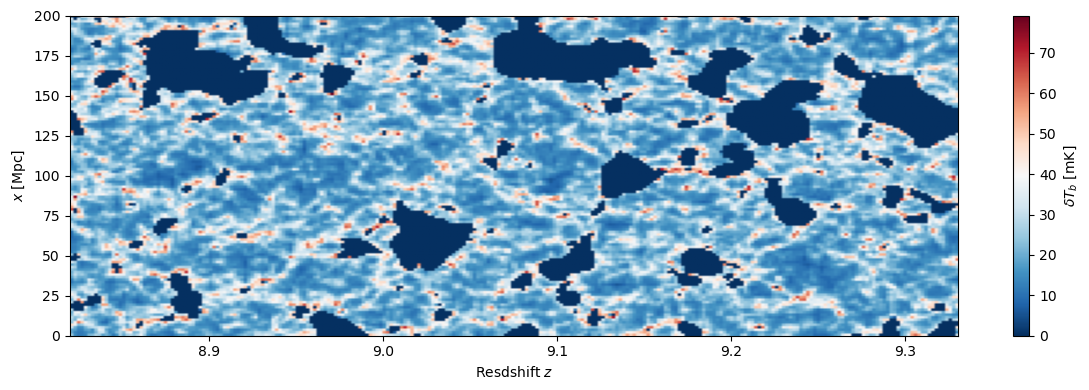

In [6]:
# Read h5py file for slice of lightcone iz-th redshift and i-th realisation
ix = np.random.randint(ngrid)

with h5py.File(file, 'r') as f:
    lc = f['brightness_lightcone'][i, :, ix, :]  # Reads only (nz, n, n), not entire data

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
im = ax.imshow(
    lc,
    extent=(redshifts.min(), redshifts.max(), 0, box_length),
    origin='lower', cmap='RdBu_r', aspect='auto'
    )
ax.set_xlabel(r'Resdshift $z$')
ax.set_ylabel(r'$x$ [Mpc]')
plt.colorbar(im, label=r'$\delta T_b$ [mK]')
fig.tight_layout()

## Apply SKA AA* observational effects

This is the procedure also followed in `compute_statistic`.

In [7]:
# read lightcone
with h5py.File(file, 'r') as f:
    lc = f['brightness_lightcone'][np.random.randint(nrand), ...]
# move los axis to match t2c
lc = np.moveaxis(lc, 0, 2)

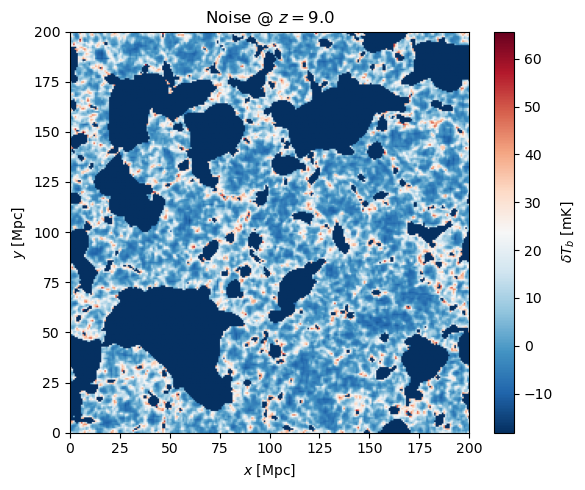

In [8]:
iz = np.abs(redshifts-9).argmin()

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(
    t2c.subtract_mean_signal(lc, los_axis=2)[..., iz],
    extent=(0, box_length, 0, box_length),
    origin='lower', cmap='RdBu_r', aspect='auto',
    # vmin=-np.max(np.abs(lc[..., iz])), vmax=np.max(np.abs(lc[..., iz])),
    )
ax.set_xlabel(r'$x$ [Mpc]')
ax.set_ylabel(r'$y$ [Mpc]')
plt.colorbar(im, label=r'$\delta T_b$ [mK]')
ax.set_title(rf'Noise @ $z={redshifts[iz]:.1f}$')
fig.tight_layout()

In [9]:
# SKA obs parameters
obs_time = 1000.  # hours
int_time = 10.  # seconds
total_int_time = 6.  # hours per day
declination = -30.0  # declination of the field in degrees
bmax = 2. * units.km  # km

In [10]:
subarray_type_list = ["AAstar", "AA4"]
noise_lc = {}

for subarray_type in subarray_type_list: 
    save_uvmap = ddir+f'uvmap_{subarray_type}_{total_int_time}h_perday.h5'
    print(f'The uv weight maps will be saved as {save_uvmap}') 
    
    # generate noise lightcone
    noise_lc[subarray_type] = t2c.noise_lightcone(
        ncells=ngrid,
        zs=redshifts,
        obs_time=obs_time,
        total_int_time=total_int_time,
        int_time=int_time,
        declination=declination,
        subarray_type=subarray_type,
        boxsize=box_length,
        verbose=False,
        save_uvmap=save_uvmap,  # save uv coverage to re-use for each realisation
        n_jobs=1, #4,
        checkpoint=16,
    )  # third axis is line of sight
    print(subarray_type, np.std(lc), np.std(noise_lc[subarray_type]))

The uv weight maps will be saved as ./SKA_chapter_simulations/uvmap_AAstar_6.0h_perday.h5
Creating the uv maps.


100%|██████████| 128/128 [00:00<00:00, 633849.96it/s]

Creating noise...


AAstar 13.220881390656988 2284.0564945376477
The uv weight maps will be saved as ./SKA_chapter_simulations/uvmap_AA4_6.0h_perday.h5
Creating the uv maps.


100%|██████████| 128/128 [00:00<00:00, 530504.85it/s]

Creating noise...


AA4 13.220881390656988 778.8418741816503


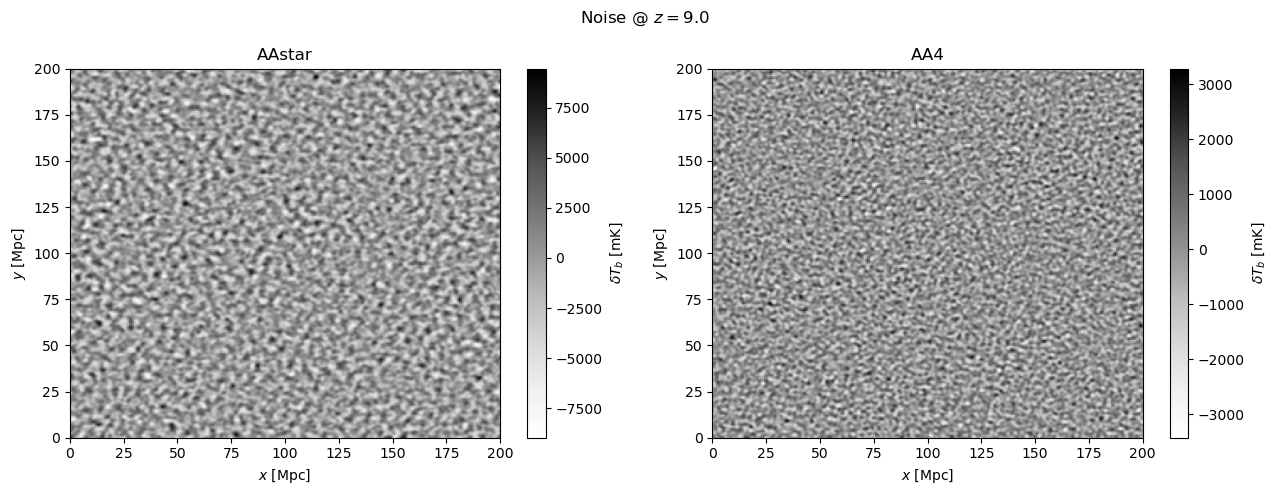

In [11]:
iz = np.abs(redshifts-9).argmin()

fig, axs = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle(rf'Noise @ $z={redshifts[iz]:.1f}$')
for i,subarray_type in enumerate(subarray_type_list): 
    ax = axs[i]
    im = ax.imshow(
        noise_lc[subarray_type][..., iz],
        extent=(0, box_length, 0, box_length),
        origin='lower', cmap='Greys', aspect='auto'
        )
    ax.set_xlabel(r'$x$ [Mpc]')
    ax.set_ylabel(r'$y$ [Mpc]')
    fig.colorbar(im, ax=ax, label=r'$\delta T_b$ [mK]')
    ax.set_title(rf'{subarray_type}')
fig.tight_layout()

In [12]:
subarray_type_list = ["AAstar", "AA4"]
noise_cc = {}

for subarray_type in subarray_type_list: 
    save_uvmap = ddir+f'uvmap_{subarray_type}_{total_int_time}h_perday.h5'
    print(f'The uv weight maps will be saved as {save_uvmap}') 
    
    # generate noise lightcone
    noise_cc[subarray_type] = t2c.noise_cube_coeval(
        ncells=ngrid,
        z=redshifts[0],
        obs_time=obs_time,
        total_int_time=total_int_time,
        int_time=int_time,
        declination=declination,
        subarray_type=subarray_type,
        boxsize=box_length,
        verbose=False,
        # save_uvmap=save_uvmap,  # save uv coverage to re-use for each realisation
        # n_jobs=1, #4,
        # checkpoint=16,
    )  # third axis is line of sight
    print(np.std(noise_cc[subarray_type]))

The uv weight maps will be saved as ./SKA_chapter_simulations/uvmap_AAstar_6.0h_perday.h5
Generating uv map from daily observations...


Gridding uv tracks: 100%|██████████| 2160/2160 [00:08<00:00, 242.04it/s]


...done
AAstar 13.220881390656988 2799.328319300266
The uv weight maps will be saved as ./SKA_chapter_simulations/uvmap_AA4_6.0h_perday.h5
Generating uv map from daily observations...


Gridding uv tracks: 100%|██████████| 2160/2160 [00:22<00:00, 94.79it/s]


...done
AA4 13.220881390656988 968.8308568337114


In [12]:
noisy_lc = {ke: noise_lc[ke] + t2c.subtract_mean_signal(lc, los_axis=2)
            for ke in noise_lc.keys()}
dt_obs = {}
for i,subarray_type in enumerate(subarray_type_list): 
    dt_obs[subarray_type], zs_obs = t2c.smooth_lightcone(
        noisy_lc[subarray_type], 
        redshifts, 
        box_size_mpc=box_length,
        max_baseline=2.0, #km
    )

100%|██████████| 128/128 [00:00<00:00, 207.51it/s]


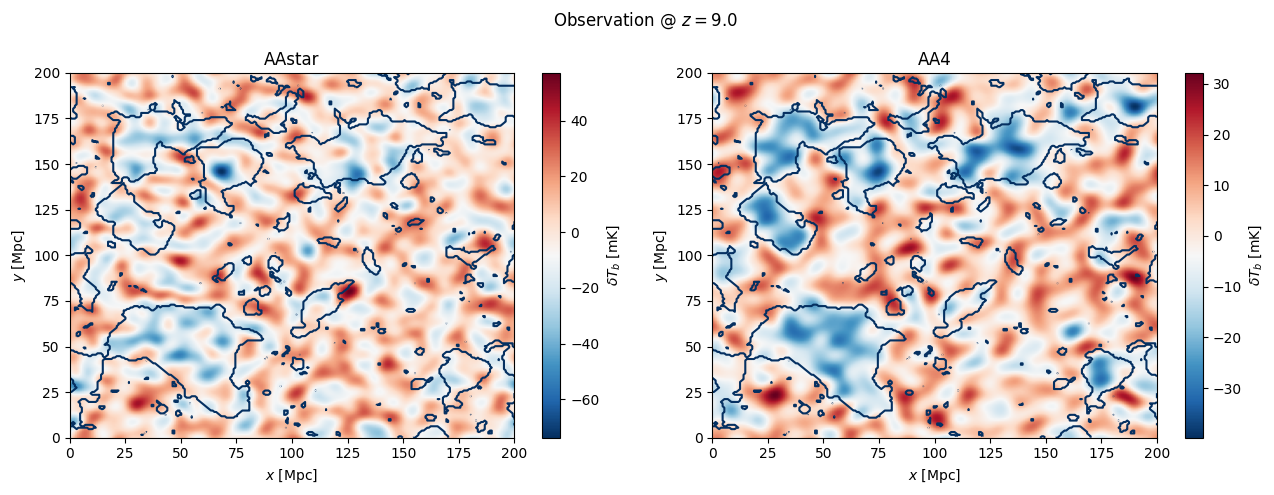

In [13]:
iz = np.abs(redshifts-9).argmin()

fig, axs = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle(rf'Observation @ $z={redshifts[iz]:.1f}$')
for i,subarray_type in enumerate(subarray_type_list): 
    ax = axs[i]
    im = ax.imshow(
        dt_obs[subarray_type][..., iz],
        extent=(0, box_length, 0, box_length),
        origin='lower', cmap='RdBu_r', aspect='auto',
        # vmin=-np.max(np.abs(lc[..., iz])), vmax=np.max(np.abs(lc[..., iz])),
        )
    xi = np.linspace(0, box_length, ngrid)
    ax.contour(xi, xi, lc[...,iz], levels=[1e-4], cmap="RdBu_r")
    ax.set_xlabel(r'$x$ [Mpc]')
    ax.set_ylabel(r'$y$ [Mpc]')
    fig.colorbar(im, ax=ax, label=r'$\delta T_b$ [mK]')
    ax.set_title(rf'{subarray_type}')
fig.tight_layout()

## Power spectrum

In [29]:
# Power spectra
nbins = 15
k_nyquist = np.pi/box_length*np.min(lc.shape)
print(f'Nyquist frequency = {k_nyquist} 1/Mpc')
box_length_los = np.abs(cos.comoving_distance(redshifts.max())-cos.comoving_distance(redshifts.min())).value
box_dims = [box_length, box_length, box_length_los] # This is important as the third or los axis has a different physical length.
# Fiducial 
ps, ks = t2c.power_spectrum_1d(lc, kbins=nbins, box_dims=box_dims)
pn = {ke: t2c.power_spectrum_1d(noise_lc[ke], kbins=nbins, box_dims=box_dims)[0][ks<k_nyquist/2]
      for ke in noise_lc.keys()}
ps, ks = ps[ks<k_nyquist], ks[ks<k_nyquist]

Nyquist frequency = 2.0106192982974678 1/Mpc


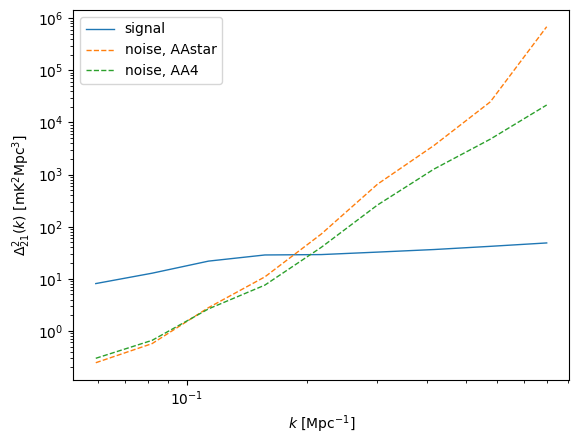

In [28]:
fig, ax = plt.subplots()
ax.loglog(ks, ps*ks**3/2/np.pi**2, lw=1., ls='-', label='signal')
for ke in pn.keys():
    ax.loglog(ks, pn[ke]*ks**3/2/np.pi**2, lw=1., ls='--', label=f'noise, {ke}')
ax.set_ylabel(r'$\Delta^2_{21}(k)$ [mK$^2$Mpc$^3$]')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
# ax.axis([3e-2,2.5,9e-2,5e2])
ax.legend()

In [16]:
subarray_type_list = ["AAstar", "AA4"]
nsims = 10
kbins = 15

pns = {}
for subarray_type in subarray_type_list: 
    pns[subarray_type] = np.zeros((nsims,kbins))
    save_uvmap = ddir+f'uvmap_{subarray_type}_{total_int_time}h_perday.h5'
    print(f'The uv weight maps will be saved as {save_uvmap}') 
    for i in tqdm(range(nsims)):
        # generate noise lightcone
        nn_ = t2c.noise_lightcone(
            ncells=ngrid,
            zs=redshifts,
            obs_time=obs_time,
            total_int_time=total_int_time,
            int_time=int_time,
            declination=declination,
            subarray_type=subarray_type,
            boxsize=box_length,
            verbose=False,
            save_uvmap=save_uvmap,  # save uv coverage to re-use for each realisation
            n_jobs=1, #4,
            checkpoint=16,
        )  # third axis is line of sight
        ps_, ks_ = t2c.power_spectrum_1d(nn_, kbins=kbins, box_dims=box_dims)
        pns[subarray_type][i,:] = ps_
    pns['k'] = ks_

The uv weight maps will be saved as ./SKA_chapter_simulations/uvmap_AAstar_6.0h_perday.h5


  0%|          | 0/10 [00:00<?, ?it/s]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 679583.43it/s]

Creating noise...



 10%|█         | 1/10 [00:01<00:16,  1.80s/it]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 639132.04it/s]


Creating noise...


 20%|██        | 2/10 [00:03<00:14,  1.86s/it]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 672770.57it/s]


Creating noise...


 30%|███       | 3/10 [00:05<00:12,  1.83s/it]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 689179.60it/s]


Creating noise...


 40%|████      | 4/10 [00:07<00:10,  1.81s/it]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 666920.39it/s]


Creating noise...


 50%|█████     | 5/10 [00:09<00:09,  1.82s/it]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 675309.32it/s]


Creating noise...


 60%|██████    | 6/10 [00:10<00:07,  1.82s/it]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 710146.71it/s]


Creating noise...


 70%|███████   | 7/10 [00:12<00:05,  1.81s/it]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 697234.95it/s]


Creating noise...


 80%|████████  | 8/10 [00:14<00:03,  1.81s/it]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 700875.86it/s]


Creating noise...


 90%|█████████ | 9/10 [00:16<00:01,  1.81s/it]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 673614.70it/s]


Creating noise...


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


The uv weight maps will be saved as ./SKA_chapter_simulations/uvmap_AA4_6.0h_perday.h5


  0%|          | 0/10 [00:00<?, ?it/s]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 724522.15it/s]


Creating noise...


 10%|█         | 1/10 [00:01<00:16,  1.82s/it]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 676159.84it/s]


Creating noise...


 20%|██        | 2/10 [00:03<00:14,  1.80s/it]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 678724.29it/s]


Creating noise...


 30%|███       | 3/10 [00:05<00:12,  1.79s/it]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 671088.64it/s]


Creating noise...


 40%|████      | 4/10 [00:07<00:10,  1.81s/it]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 655520.04it/s]


Creating noise...


 50%|█████     | 5/10 [00:08<00:08,  1.79s/it]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 692736.66it/s]


Creating noise...


 60%|██████    | 6/10 [00:10<00:07,  1.80s/it]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 676159.84it/s]


Creating noise...


 70%|███████   | 7/10 [00:12<00:05,  1.80s/it]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 707339.81it/s]


Creating noise...


 80%|████████  | 8/10 [00:14<00:03,  1.78s/it]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 689179.60it/s]


Creating noise...


 90%|█████████ | 9/10 [00:16<00:01,  1.81s/it]

Creating the uv maps.



100%|██████████| 128/128 [00:00<00:00, 685658.89it/s]


Creating noise...


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


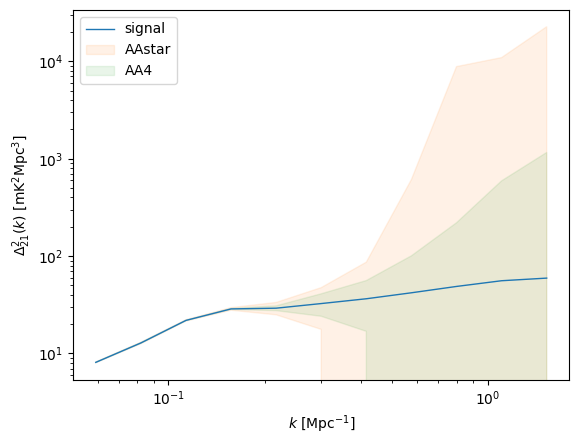

In [30]:
fig, ax = plt.subplots()
ax.loglog(ks, ps*ks**3/2/np.pi**2, lw=1., ls='-', label='signal')
ax.fill_between(ks, (ps-pns['AAstar'].std(axis=0)[ks_<k_nyquist])*ks**3/2/np.pi**2, (ps+pns['AAstar'].std(axis=0)[ks_<k_nyquist])*ks**3/2/np.pi**2, color='C1', alpha=0.1, label='AAstar')
ax.fill_between(ks, (ps-pns['AA4'].std(axis=0)[ks_<k_nyquist])*ks**3/2/np.pi**2, (ps+pns['AA4'].std(axis=0)[ks_<k_nyquist])*ks**3/2/np.pi**2, color='C2', alpha=0.1, label='AA4')
ax.set_ylabel(r'$\Delta^2_{21}(k)$ [mK$^2$Mpc$^3$]')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
# ax.axis([3e-2,2.5,9e-2,5e2])
ax.legend()